Implements "Generating Text with Recurrent Neural Networks" (https://icml.cc/2011/papers/524_icmlpaper.pdf)

<img src="rnn.jpeg" />



DATA
Total characters: 40,888
Unique characters: 100
Training chunk length: 200

MODEL
Input size: 100
Hidden size: 256
Factor size: 256
Number of layers: 1
Total parameters: 249,188

TRAIN
Learning rate: 0.002
Number of epochs: 10000
Gradient clipping: 1.0
Device: cpu
--------------------------------------------------

epoch: 2/10000, loss: 4.6304, mfu: 0.81%
epoch: 4/10000, loss: 4.6098, mfu: 0.79%
epoch: 6/10000, loss: 4.5923, mfu: 0.80%
epoch: 8/10000, loss: 4.5633, mfu: 0.82%
epoch: 10/10000, loss: 4.5192, mfu: 0.79%
epoch: 12/10000, loss: 4.4842, mfu: 0.78%
epoch: 14/10000, loss: 4.4358, mfu: 0.81%
epoch: 16/10000, loss: 4.3552, mfu: 0.78%
epoch: 18/10000, loss: 4.2501, mfu: 0.83%
epoch: 20/10000, loss: 4.1292, mfu: 0.83%
epoch: 22/10000, loss: 3.9048, mfu: 0.78%
epoch: 24/10000, loss: 3.8667, mfu: 0.83%
epoch: 26/10000, loss: 3.5477, mfu: 0.83%
epoch: 28/10000, loss: 3.5051, mfu: 0.80%
epoch: 30/10000, loss: 3.1847, mfu: 0.80%
epoch: 32/10000, loss: 3.2098, mfu: 0.84%
epoch: 34

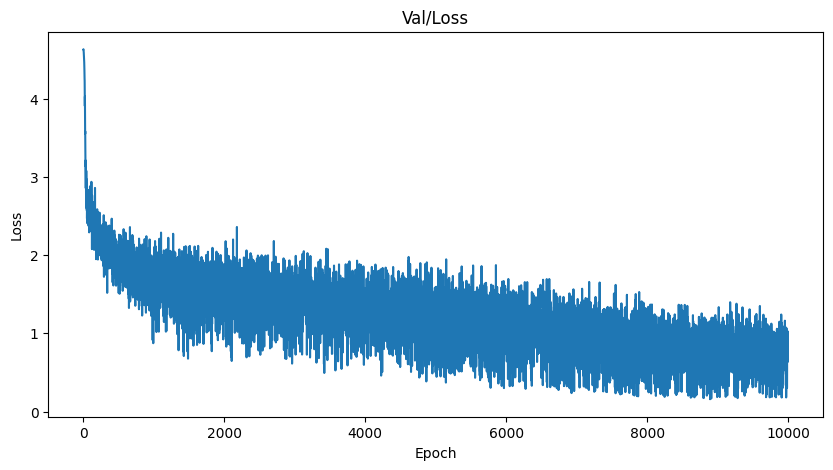


SAMPLE:



/var/folders/lv/fs2j5vr90zz71f7mbvytr3s80000gn/T/ipykernel_16440/3957509678.py:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mode

First off y makin' doin'
shank this in her
Y'all be like a fattle are goes on
How many brothers fell victim to the and the way it is
Things down with me
But they clown away
The motherfuckers, it's what they can't adjust, whank to find without havin fell keep on your Glocks
That's just the shit go better from her
You up
California knows how I gotta rown
Talkin' all my collin' with me roama Is the rules
I'm high
They got me and if it's I never be the concrete?
Packin' in the city, there's nobody heartle with a menaces
I say the first shit
What really on the way it is
Things'll never live peace, young nigga, I are appreciated)
Sweet lady, place no one else even though they don't never left the way it is
Things'll never learned to a G
Let's gettin' around with me

ugh

You gave your fall the drawless on me
But the made it, shouldered for we White what you raised me buried up in they can my Eddie FRESH ain't fuck, you left and party
Cali when the way it is
Things'll be a motherfuckers
Nigga

In [56]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import string
import random
import time
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 10000
PRINT_EVERY = 2
LEARNING_RATE = 2e-3
PREDICT_LENGTH = 50 
TEMPERATURE = 0.8
CHUNK_LENGTH = 200
CHARACTERS = string.printable # all printable ASCII characters
INPUT_PATH = 'data/tupac.txt'
INPUT_SIZE = OUTPUT_SIZE = len(CHARACTERS) 
HIDDEN_SIZE = 256
FACTOR_SIZE = 256 # multiplicative interaction factor
NUM_LAYERS = 1
GRAD_CLIP = 1.0 # prevents exploding gradients
DROPOUT = 0.0
WARMUP_EPOCHS = 100 
MIN_LR = 1e-4

class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        return self.gamma * (x - mean) / (var + self.eps).sqrt() + self.beta

class MultiplicativeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, factor_size, output_size, num_layers, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.factor_size = factor_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        init_scale = 0.1
        
        self.encoder = nn.Embedding(input_size, hidden_size) # one-hot encoding
        self.encoder_norm = LayerNorm(hidden_size) # normalize input embeddings
        
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'W_fx': nn.Linear(hidden_size, factor_size, bias=False),
                'W_fh': nn.Linear(hidden_size, factor_size, bias=False),
                'W_hf': nn.Linear(factor_size, hidden_size, bias=True),
                'layer_norm': LayerNorm(hidden_size)
            }) for _ in range(num_layers)
        ])
        
        self.decoder = nn.Linear(hidden_size, output_size) # output layer
        
        for name, p in self.named_parameters():
            if p.dim() > 1:
                if 'W_fx' in name or 'W_fh' in name:
                    nn.init.orthogonal_(p, gain=init_scale)
                else:
                    nn.init.xavier_normal_(p, gain=init_scale)

    def forward(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        encoded = self.encoder_norm(encoded) 
        encoded = nn.functional.dropout(encoded, p=self.dropout, training=self.training)
        
        new_hidden = []
        current_input = encoded
        
        for layer_idx, layer in enumerate(self.layers):
            prev_hidden = hidden[layer_idx].view(1, -1)
            
            f_t = layer['W_fx'](current_input) * torch.sigmoid(layer['W_fh'](prev_hidden))
            h_t = torch.tanh(layer['W_hf'](f_t))
            
            h_t = layer['layer_norm'](h_t + current_input)
            h_t = nn.functional.dropout(h_t, p=self.dropout, training=self.training)
            
            new_hidden.append(h_t.view(1, 1, -1))
            current_input = h_t
        
        output = self.decoder(current_input)
        hidden = torch.cat(new_hidden, dim=0)
        
        return output.view(1, -1), hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.num_layers, 1, self.hidden_size))

def get_lr(epoch):
    """Cosine annealing learning rate with warmup"""
    if epoch < WARMUP_EPOCHS:
        return LEARNING_RATE * (epoch / WARMUP_EPOCHS)
    progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
    return MIN_LR + (LEARNING_RATE - MIN_LR) * 0.5 * (1 + np.cos(np.pi * progress))

def estimate_flops(model, sequence_length, batch_size):
    """Estimate the number of FLOPs for a given sequence length and batch size"""
    H = HIDDEN_SIZE
    F = FACTOR_SIZE
    V = INPUT_SIZE
    L = sequence_length
    B = batch_size
    
    flops = B * L * (
        2 * H * F +
        2 * H * F +
        F +
        2 * F * H +
        2 * H * V
    )
    return flops

def char_tensor(string):
    """Convert a string to a tensor of character indices"""
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = CHARACTERS.index(string[c])
        except ValueError:
            continue
    return Variable(tensor)

def random_chunk(data):
    """Get a random chunk of data"""
    start_idx = random.randint(0, len(data) - CHUNK_LENGTH)
    end_idx = start_idx + CHUNK_LENGTH + 1
    chunk = data[start_idx:end_idx]
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

def generate(model, prime_str='A', predict_len=100, temperature=0.8):
    """Sample a sequence of characters from saved checkpoint"""
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    for p in range(len(prime_str)):
        _, hidden = model(prime_input[p], hidden)

    inp = prime_input[-1]

    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_idx = torch.multinomial(output_dist, 1)[0]
        predicted_char = CHARACTERS[top_idx]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

def print_model_info(model, data):
    num_params = sum(p.numel() for p in model.parameters())
    print(f"\nDATA")
    print(f"Total characters: {len(data):,}")
    print(f"Unique characters: {len(CHARACTERS)}")
    print(f"Training chunk length: {CHUNK_LENGTH}")
    print(f"\nMODEL")
    print(f"Input size: {INPUT_SIZE}")
    print(f"Hidden size: {HIDDEN_SIZE}")
    print(f"Factor size: {FACTOR_SIZE}")
    print(f"Number of layers: {NUM_LAYERS}")
    print(f"Total parameters: {num_params:,}")
    print(f"\nTRAIN")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Number of epochs: {EPOCHS}")
    print(f"Gradient clipping: {GRAD_CLIP}")
    print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
    print("-" * 50 + "\n")

def train(model, data):
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    best_loss = float('inf')
    losses = []
    
    try:
        for epoch in range(EPOCHS):
            model.train()
            start_time = time.time()
            
            current_lr = get_lr(epoch)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            
            inp, target = random_chunk(data)
            hidden = model.init_hidden()
            model.zero_grad()
            loss = 0

            for c in range(CHUNK_LENGTH):
                output, hidden = model(inp[c], hidden)
                loss += criterion(output, target[c].view(1))

            if torch.isnan(loss):
                print(f"NaN loss detected at epoch {epoch+1}. Stopping training.")
                break

            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            loss = loss.item() / CHUNK_LENGTH
            losses.append(loss)
            
            if loss < best_loss:
                best_loss = loss
                torch.save(model.state_dict(), 'best_model.pt')
            
            if (epoch + 1) % PRINT_EVERY == 0:
                time_per_epoch = time.time() - start_time
                flops = estimate_flops(model, CHUNK_LENGTH, 1)
                flops_per_sec = flops / time_per_epoch if time_per_epoch > 0 else 0
                print(f'epoch: {epoch+1}/{EPOCHS}, loss: {loss:.4f}, mfu: {flops_per_sec/1e9:.2f}%')

        plt.figure(figsize=(10, 5))
        plt.plot(losses)
        plt.title('Val/Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.close()
        
    except KeyboardInterrupt:
        print('Training interrupted')


with open(INPUT_PATH, 'r', encoding='utf-8') as f:
    data = f.read()

model = MultiplicativeRNN(
    INPUT_SIZE,
    HIDDEN_SIZE,
    FACTOR_SIZE,
    OUTPUT_SIZE,
    NUM_LAYERS,
    DROPOUT
)

print_model_info(model, data)
train(model, data)

print("\nSAMPLE:\n")
model.load_state_dict(torch.load('best_model.pt'))
print(generate(model, 'First off ', 1000))


In [57]:
model = MultiplicativeRNN(
        INPUT_SIZE,
        HIDDEN_SIZE,
        FACTOR_SIZE,
        OUTPUT_SIZE,
        NUM_LAYERS,
        DROPOUT
    )
model.load_state_dict(torch.load('best_model.pt'))
print(generate(model, 'First off ', 2000))

/var/folders/lv/fs2j5vr90zz71f7mbvytr3s80000gn/T/ipykernel_16440/1334155755.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

First off thing will had the streets, shake it, baby
Shake it, alone, it back down; gird tall as a boss playa, 'cause even world, nigga, there's a heaven for me back to rape from gettin' my buck it
With me
I won
I see me when I die
Live the Sacs of a woman and get niggas got money homie
Got eati
witness to be we keep inside, share with me, we breathe the same
Talk without the rose it gonna runnin' crack
And the day I cowally time the ocalized yal, learn that had dhot the way it is, aww yeah

 all the way it is
Things a lot somethin they can't do nothin' like like a pass, and like a man in peace, young nigga, then that beat bet it right
Fo'le, it's right vick was to get be me under moothin' to get me
How many brothers seconds die down? city, Cali
Uh, crack you couldn't coes when they grind, nigga, there's a heaven for a G
In they come right me

I won't see you paid and runnin' like a woman as no one above shotTernatim to sing!"
Don't you listenin'
I been gettin' motherfuckers life the s